----------------------------
# Exercise 1.2


In [344]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random
import itertools
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook

In [345]:
# splitting data in train test and val set
def data_split(data, val = True):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    if val == False:
        return X_train.T, X_val.T, y_train, y_val
    
    else:
    # val-test split 30% -> 15% - 15%
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
        return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel(r'C:\Users\RE-Giorgio\Downloads\dataPoints.xlsx')
random.seed(1696991)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)

In [346]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.c = self.X.T[np.random.randint(self.X.shape[1], size=self.N),:]
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.X.shape[0], self.N), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(2)]))
        c, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(2)]
        return c, v
    
    # objective function to minimize
    def loss(self,params):
        
        c, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, c, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, c, v):
        return 0.5 * np.mean(np.square(self.predict(X, c, v) - y)) 

In [23]:
# Mlp inherits the general charectiristics of a shallow nn 
class Rbf(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def phi(self, x, c):
        
        x_c = np.stack([x.T]*self.N) - np.split(c.T, self.N)
        phi = np.exp(-np.square(np.array([np.linalg.norm(arr, axis = 1) for arr in (x_c)])/self.sigma))

        return phi
    
#     def predict(self, x, c, v):

#         H = self.phi(x, c)
#         self.output = v @ H
#         return self.output
#         def c_der(self, c):
        
#         x_c = (np.stack([self.X.T]*self.N) - np.split(c.T, self.N))
#         der = -2* x_c/np.square(self.sigma)
#         phi = np.expand_dims( self.gaussian(np.array([np.linalg.norm(arr, axis = 1)
#                                                  for arr in x_c])), 2)
#         return  der * phi

    
#     def gaussian(self, r):
#         return np.exp(-np.square(r/self.sigma))

        
#     def grad(self, params):
        
#         c, v = self.separate(params)
#         H = self.phi(self.X, c)
#         f_x = v @ H
        
#         #print((np.sum(((v.T @ (f_x - self.y)) @ self.c_der_0(c).T), axis = 1, keepdims = True)).shape, c.T[:,0].shape)
#         dc = (1/self.X.shape[1]) * np.sum( np.expand_dims(2*self.rho*c.T, 1) +
#                                                        ((np.expand_dims((v.T.dot(f_x - self.y)), 2))
#                                                         * self.c_der(c)) *-1, axis = 1, keepdims = True)
#         dv = 2*self.rho*v + (1/self.X.shape[1]) * (f_x-y_train).dot(H.T)
#         #dc = np.hstack([dc_0, dc_1])
#         #print(dc_0.shape, dc_1.shape)
#         return np.concatenate([array.reshape(-1) for array in [np.squeeze(dc), dv]])
    
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.c, self.v]])
        
        print("training...", "\n")
        start = time.time()
        result =  minimize(self.loss, x0 = inits, method = self.method)#, jac = self.grad)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        # optimal parameters
        self.c, self.v = self.separate(result.x)
        
        return result.nfev, result.njev, result.nit, result.fun, result.jac, time_elapsed

In [28]:
nn = Rbf(X_train, y_train, N = 35, sigma = 0.7, rho = 10e-5, method = "BFGS")
nfev, njev, nit, fun, jac, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.c, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.c, nn.v)) # 0.0446159739248811

training... 

      fun: 0.02748039676174558
 hess_inv: array([[ 326.28231102,  -11.82640657,   35.96281979, ...,  -41.72049375,
         -30.00364322, -105.78044958],
       [ -11.82640657,  124.07611873,   24.83370554, ...,  -15.68440751,
          -8.08327586,   19.58412372],
       [  35.96281979,   24.83370554,  209.15850453, ...,  -31.68762986,
          28.3646042 ,   61.44875466],
       ...,
       [ -41.72049375,  -15.68440751,  -31.68762986, ...,  319.79905807,
         -76.36296288, -251.79949167],
       [ -30.00364322,   -8.08327586,   28.3646042 , ...,  -76.36296288,
          73.96717888,   59.10168296],
       [-105.78044958,   19.58412372,   61.44875466, ..., -251.79949167,
          59.10168296,  558.46022704]])
      jac: array([-3.26428562e-06,  5.97909093e-07,  2.23936513e-06,  5.75557351e-07,
       -4.33437526e-06,  9.98144969e-07, -2.91969627e-07,  9.82079655e-07,
       -6.23986125e-07,  1.48126855e-06,  9.93255526e-07, -4.94089909e-06,
        2.18208879e-06,

In [29]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure(figsize = [20,10])
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(-1, 1, 200)
    x2 = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.c, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

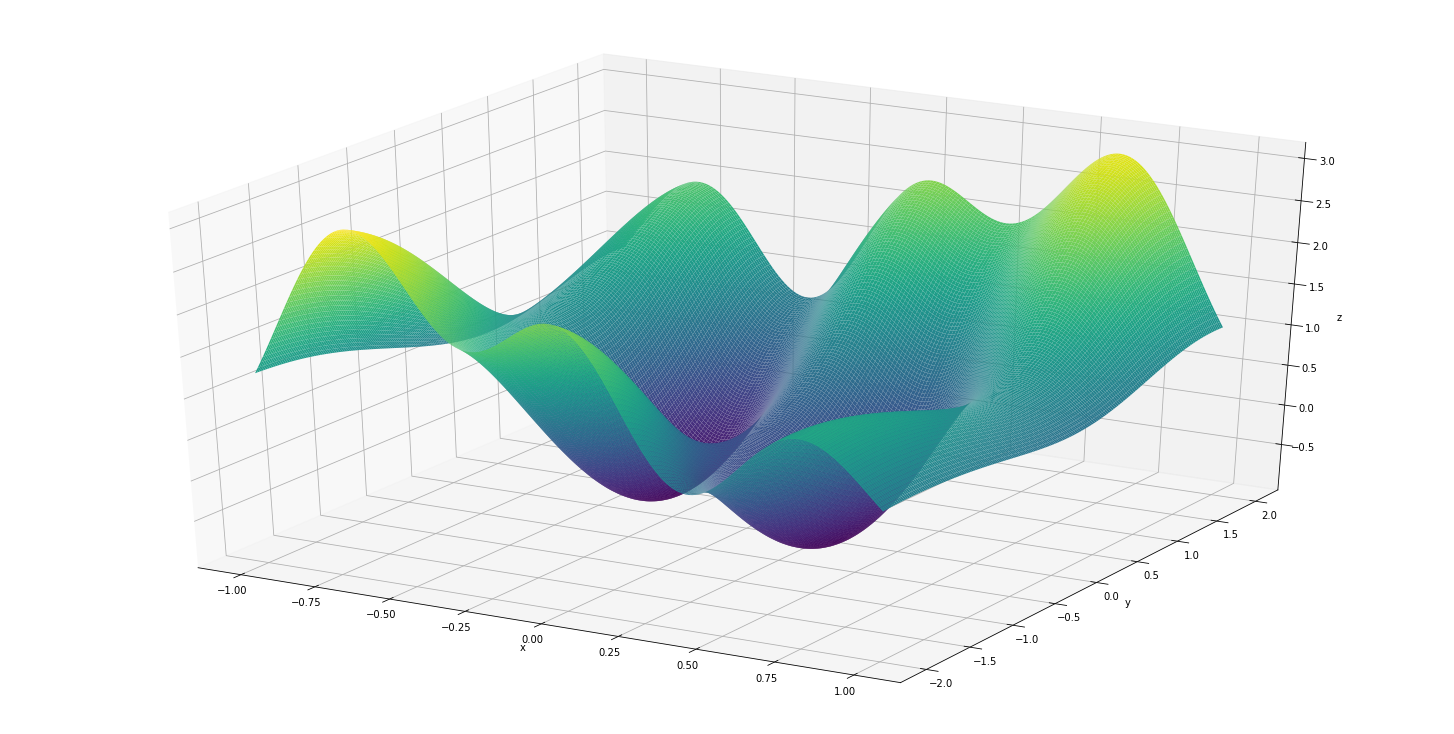

In [30]:
plot(nn)

---------------
# Exercise 2.2

In [348]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None, seed = 1):
        


        self.X = X
        self.y = y
        self.N = N
        np.random.seed(seed)
        self.c = self.X.T[np.random.randint(self.X.shape[1], size=self.N),:]
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method
        
    # clustering
    def pick_clusters(self, X):
        km = KMeans(n_clusters=self.N, init = "k-means++").fit(X.T)
        print(km.cluster_centers_.T)
        return km.cluster_centers_.T[0:2,:]

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.X.shape[0], self.N), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(2)]))
        c, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(2)]
        return c, v
    
    # objective function to minimize
    def loss(self,params):
        
        v = params
        return 0.5 * np.mean(np.square((self.predict(self.X, self.c, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(np.concatenate([array.reshape(-1) for array in [self.c, v]])))
    
    # metric for train and test accuracy
    def mse(self, X, y, c, v):
        return 0.5 * np.mean(np.square(self.predict(X, c, v) - y)) 

In [369]:
# Mlp inherits the general charectiristics of a shallow nn 
class Rbf_el(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def phi(self, x, c):
        x_c = np.stack([x.T]*self.N) - np.split(c, self.N)
        phi = np.exp(-np.square(np.array([np.linalg.norm(arr, axis = 1) for arr in (x_c)])/self.sigma))

        return phi
    
    def predict(self, x, c, v):

        H = self.phi(x, c)
        self.output = v @ H
        return self.output
    
    def grad(self, v):
        
        H = self.phi(self.X,self.c)
        dv = 2*self.rho*v + (1/self.X.shape[1]) * (H @ ((H.T @ v) - self.y).T )
        
        return dv
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = self.v
        
        #print("training...", "\n")
        start = time.time()
        result =  minimize(self.loss, x0 = inits, method = self.method, jac = self.grad, tol = 10e-3)
        time_elapsed = time.time() - start
        #print(result)
        #print("finished training.")
        
        # optimal parameters
        self.v = result.x
        
        return result.nfev, result.njev, result.nit, result.fun, result.jac, time_elapsed

In [360]:
nn = Rbf_el(X_train, y_train, N = 35, sigma = 0.7, rho = 10e-5, method = "BFGS", seed = 2)
nn.optimize()

      fun: 0.16780938819376207
 hess_inv: array([[  2.17992351,   0.9318919 ,   0.79271558, ...,  -2.62835133,
          0.43106377,   0.15468883],
       [  0.9318919 ,   1.98857314,   0.55228835, ...,  -1.10152945,
         -0.21282607,  -0.65490582],
       [  0.79271558,   0.55228835,   4.37945517, ...,  -4.19310714,
          0.70023331,   0.81138185],
       ...,
       [ -2.62835133,  -1.10152945,  -4.19310714, ...,  19.00621619,
         -7.05438539, -11.03504617],
       [  0.43106377,  -0.21282607,   0.70023331, ...,  -7.05438539,
          4.46144411,   5.88922133],
       [  0.15468883,  -0.65490582,   0.81138185, ..., -11.03504617,
          5.88922133,  13.07838359]])
      jac: array([ 2.37160591e-03, -4.32082646e-03,  1.14798367e-03, -5.96766192e-03,
        3.54933145e-03,  3.72530672e-03, -7.68562165e-04,  7.46270632e-03,
        9.12745616e-04, -9.70835829e-03,  5.37898483e-04,  3.35199024e-03,
        6.82890474e-04, -6.02371327e-04,  6.29360448e-05,  1.24574480e-03

(28,
 28,
 27,
 0.16780938819376207,
 array([ 2.37160591e-03, -4.32082646e-03,  1.14798367e-03, -5.96766192e-03,
         3.54933145e-03,  3.72530672e-03, -7.68562165e-04,  7.46270632e-03,
         9.12745616e-04, -9.70835829e-03,  5.37898483e-04,  3.35199024e-03,
         6.82890474e-04, -6.02371327e-04,  6.29360448e-05,  1.24574480e-03,
        -1.97687217e-03,  2.97161864e-03, -3.15066451e-03, -2.05561450e-03,
         4.43374983e-03, -1.74657518e-03, -1.37973079e-03, -2.41651756e-03,
         2.07707907e-03, -4.51736861e-03,  8.21126122e-04, -1.68852055e-03,
        -4.02232401e-03,  3.09906336e-03, -1.81386466e-03,  3.13740592e-03,
        -7.86242055e-05,  2.87649417e-03, -1.22906178e-03]),
 0.04389452934265137)

In [366]:
# extreme  learning traning
print("training...", "\n")
start = time.time()
num_it = 10000

test_mses = {}
train_mses = {}
for i in tqdm_notebook(range(num_it)):
    
    s = np.random.randint(1000000000)
    nn = Rbf_el(X_train, y_train, N = 35, sigma = 0.7, rho = 10e-5, seed = s)
    nn.optimize()
    
    train_mses[s] = nn.mse(X_train, y_train, nn.c, nn.v)
    test_mses[s] = nn.mse(X_test, y_test, nn.c, nn.v)
    
time_elapsed = time.time() - start
print("finished training.")

opt_seed = min(test_mses, key=train_mses.get)
print("Train Error :", min(list(train_mses.values())))
print("Test Error :", min(list(test_mses.values())))# 0.03 538366619
print("Seed :", opt_seed)

training... 



finished training.
Train Error : 0.06496681236574113
Test Error : 0.07018252813291007
Seed : 460586237


In [367]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure(figsize = [20,10])
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(-1, 1, 200)
    x2 = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.c, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap = "viridis", edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

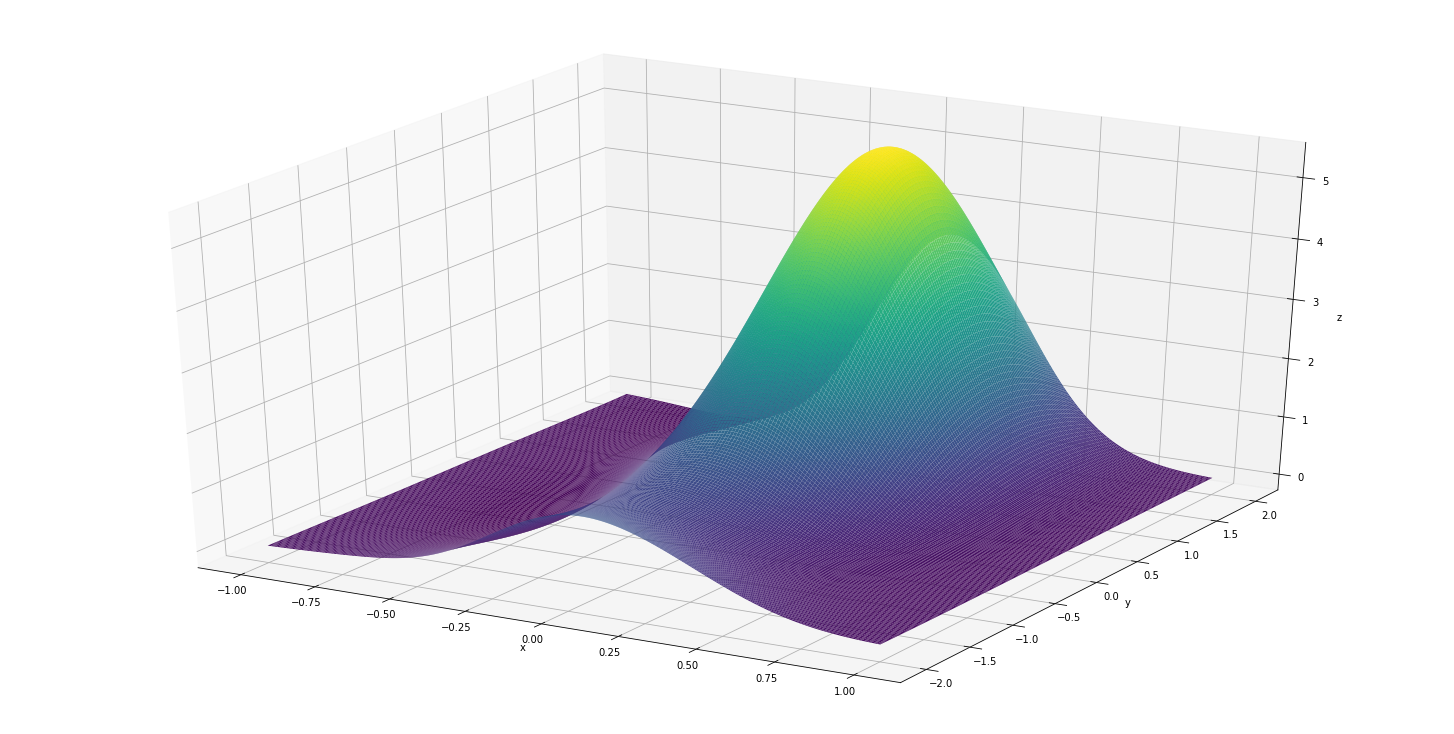

In [368]:
nn = Rbf_el(X_train, y_train, N = 35, sigma = 0.7, rho = 10e-5, seed = opt_seed)
plot(nn)